# Installing dependencies

In [ ]:
#Installing all necessary dependencies, assuming that Conda/Anaconda already installed
!conda install -y -c bioconda sra-tools
!conda install -y -c bioconda fastqc
!conda install -y -c bioconda freebayes
!conda install -y -c bioconda VCFtools
!conda install -y -c bioconda trimmomatic
!conda install -y -c bioconda bwa
!conda install -y -c bioconda samtools

# Dictionary of necessary files

In [1]:
sra_accessions = {#Meloidogyne incognita 
                    'MincHarC':['SRR4242466','SRR4242465'], 'MincL19':['SRR4242479'], 'MincL9'  :['SRR4242469'],
                    'MincVW6' :['SRR4242464','SRR4242463'], 'MincL27':['SRR4242470'], 'Minc557R':['SRR4242467'],
                    'MincW1'  :['SRR4242461','SRR4242460'], 'MincA14':['SRR4242456'],  
                  #Heterorhabditis bacteriophora 
                    'HbactGebreg2a1223': ['SRR6846592'], 
                  #Rotylenchulus reniformis 
                    'RreniWGA':['SRR2032116'], 'RreniMP': ['SRR2029861'], 
                  #Acrobeloides nanus 
                    'Ananu':['SRR7511511'], 
                  #Globodera rostochiensis 
                    'GrostS001385':['SRR2989854'], 'GrostSC': ['ERR123958'],
                    'GrostS00138A':['SRR2989857'], 'GrostS00138D': ['SRR2989858']}

# Getting SRA data

In [ ]:
from os import path
for smpl in sra_accessions:
    outdir = 'SRA_data/%s' % smpl
    if path.exists(outdir):
        continue
    a = !mkdir $outdir
    for acc in sra_accessions[smpl]:
        a = !fastq-dump -A $acc -O $outdir --gzip --split-files

# Quality trimming with Trimmomatic
- Delete "bad" reads
- Remove primers and adapters if there any

In [ ]:
from os import path
for smpl in sra_accessions:
    for acc in sra_accessions[smpl]:
        outdir   = 'SRA_data/%s/%s_2_paired.fq.gz'   % (smpl, acc)
        if path.exists(outdir):
            continue #checking if files already exists to skip processed samples
        input_1  = "SRA_data/%s/%s_1.fastq.gz"       % (smpl, acc)
        input_2  = "SRA_data/%s/%s_2.fastq.gz"       % (smpl, acc)
        output_1 = "SRA_data/%s/%s_1_paired.fq.gz"   % (smpl, acc)
        output_2 = "SRA_data/%s/%s_1_unpaired.fq.gz" % (smpl, acc)
        output_3 = "SRA_data/%s/%s_2_paired.fq.gz"   % (smpl, acc)
        output_4 = "SRA_data/%s/%s_2_unpaired.fq.gz" % (smpl, acc)
        !trimmomatic PE -threads 10 -phred33 $input_1 $input_2 $output_1 $output_2 $output_3 $output_4 ILLUMINACLIP:adapters.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
        !rm $input_1 $input_2 output_2 output_4 #optional cleaning, comment this line if you want to keep input files

# Running FastQC with trimmed and paired files
Checking the quality of the reads

In [ ]:
from os import path
for smpl in sra_accessions:
    for acc in sra_accessions[smpl]:
        outdir = 'SRA_data/%s/%s_2_paired_fastqc.zip' % (smpl, acc)
        if path.exists(outdir):
            continue
        a = smpl + "/*_paired.fq.gz"
        !fastqc SRA_data/$a -t 10

### If some files are in one folder in several replicates use terminal, cd to folder and merge them like: 
    cat first_file_1.fq.gz second_file_1.fq.gz > first_file_second_file_1.fq.gz
    cat first_file_2.fq.gz second_file_2.fq.gz > first_file_second_file_2.fq.gz

# BWA alignment and SNP calling

In [ ]:
from os import path
ref = "" #for different reference genomes
for smpl in sra_accessions:
    outdir = "SRA_data/%s/%s_snp_ratio.vcf.AD.FORMAT" % (smpl, smpl)
    if path.exists(outdir):
        continue
    if "Minc" in smpl:
        ref = "Reference/Meloidogyne_incognita/New_ref/Minc_anot.fasta"
    elif "Hbact" in smpl:
        ref = "Reference/Heterorhabditis_bacteriophora/Heterorhabditis_bacteriophora.fasta"
    elif "Rreni" in smpl:
        ref = "Reference/Rotylenchulus_reniformis/Rotylenchulus_reniformis.fasta"
    elif "Ananu" in smpl:
        ref = "Reference/Acrobeloides_nanus/Acrobeloides_nanus.fasta"   
    elif "Grost" in smpl:
        ref = "Reference/Globodera_rostochiensis/Globodera_rostochiensis.fasta"       
#bwa alignment
    read_1= "SRA_data/%s/%s_1_paired.fq.gz" % (smpl, '*')
    read_2= "SRA_data/%s/%s_2_paired.fq.gz" % (smpl, '*')
    sam   = "SRA_data/%s/%s_aln.sam"        % (smpl, smpl)
    !bwa index $ref
    !bwa mem -M -t 10 $ref $read_1 $read_2 > $sam
#converting sam to bam
    bam   = "SRA_data/%s/%s_aln.bam"        % (smpl, smpl)
    !samtools view -@10 -Sb $sam > $bam
#sorting and indexing bam
    sbam  = "SRA_data/%s/%s_aln_sorted.bam" % (smpl, smpl)
    !samtools sort -@10 $bam > $sbam
    !samtools index -@10 $sbam
    !rm $sam $bam #optional, cleaning to save some space
#Freebayes SNP calling
    snp_vcf = "SRA_data/%s/%s_snp_filtered.vcf" % (smpl, smpl)
    !freebayes -f $ref $sbam > $snp_vcf -N -G 10
#vcftools filtering
    freebayes_snp_vcf   = "SRA_data/%s/%s_snp_filtered.vcf" % (smpl, smpl)
    freebayes_snp_ratio = "SRA_data/%s/%s_snp_ratio.vcf"    % (smpl, smpl)
    freebayes_snp_type  = "SRA_data/%s/%s_snp_type.vcf"     % (smpl, smpl)
    freebayes_SW50      = "SRA_data/%s/%s_SW50.vcf"         % (smpl, smpl)
    !vcftools --vcf $freebayes_snp_vcf --extract-FORMAT-info AD --out $freebayes_snp_ratio
    !vcftools --vcf $freebayes_snp_vcf --get-INFO TYPE --out $freebayes_snp_type
    !vcftools --vcf $freebayes_snp_vcf --out $freebayes_SW50 --site-pi 
    !vcftools --vcf $freebayes_snp_vcf --out $freebayes_SW50 --window-pi 50
    !vcftools --vcf $freebayes_snp_vcf --out $freebayes_SW50 --freq 
    !vcftools --vcf $freebayes_snp_vcf --out $freebayes_SW50 --counts
    !vcftools --vcf $freebayes_snp_vcf --out $freebayes_SW50 --SNPdensity 50

# SNP ratio

In [2]:
import pandas as pd
import numpy as np
for smpl in sra_accessions:
    snp_df = pd.read_table("SRA_data/%s/%s_snp_ratio.vcf.AD.FORMAT" % (smpl, smpl))
    VCF_df = pd.read_table("SRA_data/%s/%s_snp_filtered.vcf" % (smpl, smpl), skiprows = 64)
    snp = pd.concat([snp_df, VCF_df], axis = 1)
    snp.columns = ['CHROM', 'POS', 'COUNT', '#CHROM', '#POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'unknown']
    snp = snp.filter(items = ['CHROM', 'POS', 'COUNT', 'REF', 'ALT'])
    snp['COUNT'] = snp['COUNT'].str.split(',').tolist()
    snp['Count_REF'] = snp['COUNT'].str[0]
    snp['Count_ALT_1'] = snp['COUNT'].str[1]
    snp['Count_ALT_2'] = snp['COUNT'].str[2]
    snp.Count_REF = snp.Count_REF.astype(float)
    snp.Count_ALT_1 = snp.Count_ALT_1.astype(float)
    snp.Count_ALT_2 = snp.Count_ALT_2.astype(float)
    snp = snp.where((pd.notnull(snp)), 0)
    snp['COUNT_ALL'] = snp['Count_REF'] + snp['Count_ALT_1'] + snp['Count_ALT_2']
    snp['Rat_REF'] = snp['Count_REF'] / snp['COUNT_ALL']
    snp['Rat_ALT_1'] = snp['Count_ALT_1'] / snp['COUNT_ALL']
    snp['Rat_ALT_2'] = snp['Count_ALT_2'] / snp['COUNT_ALL']
    type_df = pd.read_table("SRA_data/%s/%s_snp_type.vcf.INFO" % (smpl, smpl))
    snp = pd.concat([snp, type_df], axis = 1)
    snp.columns = ['CHROM', 'POS', 'COUNT', 'REF', 'ALT', 'Count_REF', 'Count_ALT_1', 'Count_ALT_2', 'COUNT_ALL', 
                   'Rat_REF', 'Rat_ALT_1', 'Rat_ALT_2', 'CHROM2', 'POS2', 'REF2', 'ALT2', 'TYPE']
    snp = snp.filter(items = ['CHROM', 'POS', 'COUNT', 'REF', 'ALT', 'Count_REF', 'Count_ALT_1', 'Count_ALT_2', 
                              'COUNT_ALL', 'Rat_REF', 'Rat_ALT_1', 'Rat_ALT_2', 'TYPE'])
    snp = snp.loc[snp['Rat_REF'] < 0.9]
    snp = snp.loc[snp['Rat_ALT_1'] < 0.9]
    snp = snp.loc[snp['Rat_ALT_2'] < 0.9]
    snp.to_csv("SRA_data/%s/%s_snp.csv" % (smpl, smpl), sep='\t')
snp

,CHROM,POS,COUNT,REF,ALT,Count_REF,Count_ALT_1,Count_ALT_2,COUNT_ALL,Rat_REF,Rat_ALT_1,Rat_ALT_2,TYPE
0,18S_G_rostochiensis_EU855120.1,172,"[0, 18150, 3750]",N,"C,T",0.0,18150.0,3750.0,21900.0,0.000000,0.828767,0.171233,"snp,snp"
2,18S_G_rostochiensis_EU855120.1,638,"[13470, 2778]",CTTTTCTG,CTTTCTG,13470.0,2778.0,0.0,16248.0,0.829025,0.170975,0.000000,del
3,ITS1_G_rostochiensis_EU855120.1,84,"[2800, 12994]",T,C,2800.0,12994.0,0.0,15794.0,0.177283,0.822717,0.000000,snp
4,ITS1_G_rostochiensis_EU855120.1,91,"[3010, 13703]",A,G,3010.0,13703.0,0.0,16713.0,0.180099,0.819901,0.000000,snp
5,ITS1_G_rostochiensis_EU855120.1,100,"[3755, 14477]",G,T,3755.0,14477.0,0.0,18232.0,0.205957,0.794043,0.000000,snp
6,ITS1_G_rostochiensis_EU855120.1,161,"[0, 3027, 14261]",N,"A,G",0.0,3027.0,14261.0,17288.0,0.000000,0.175093,0.824907,"snp,snp"
11,5.8S_G_rostochiensis_EU855120.1,139,"[11387, 1970]",C,T,11387.0,1970.0,0.0,13357.0,0.852512,0.147488,0.000000,snp
12,ITS2_G_rostochiensis_EU855120.1,35,"[1324, 5931]",T,A,1324.0,5931.0,0.0,7255.0,0.182495,0.817505,0.000000,snp
13,ITS2_G_rostochiensis_EU855120.1,66,"[2461, 12084]",C,T,2461.0,12084.0,0.0,14545.0,0.169199,0.830801,0.000000,snp
14,ITS2_G_rostochiensis_EU855120.1,81,"[2970, 15103]",G,T,2970.0,15103.0,0.0,18073.0,0.164334,0.835666,0.000000,snp


# SNP for all nematodes, table and barplot

In [3]:
import pandas as pd
from Bio import SeqIO
snp_all = pd.DataFrame({'Nematode':[], 'Locus': [], 'Position':[]})
!mkdir SRA_data/Figures #making a folder for figures
for smpl in sra_accessions:
    snp_sep = pd.DataFrame({'Locus': [], 'Position':[]})
    snp_dict = {}
    if "Minc" in smpl:
        ref = "Reference/Meloidogyne_incognita/New_ref/Minc_anot.fasta"
    elif "Hbact" in smpl:
        ref = "Reference/Heterorhabditis_bacteriophora/Heterorhabditis_bacteriophora.fasta"
    elif "Rreni" in smpl:
        ref = "Reference/Rotylenchulus_reniformis/Rotylenchulus_reniformis.fasta"
    elif "Ananu" in smpl:
        ref = "Reference/Acrobeloides_nanus/Acrobeloides_nanus.fasta"   
    elif "Grost" in smpl:
        ref = "Reference/Globodera_rostochiensis/Globodera_rostochiensis.fasta"  
    for record in SeqIO.parse(ref, "fasta"):
        snp_dict.update({record.id:str(record.seq)})
    snp = pd.read_table("SRA_data/%s/%s_snp.csv" % (smpl, smpl), index_col=0)
    df1 = pd.DataFrame([[smpl,'18S',  snp[snp['CHROM'].str.contains("18S") ]['POS'].tolist()]],columns=['Nematode','Locus','Position'])
    df2 = pd.DataFrame([[smpl,'ITS1', snp[snp['CHROM'].str.contains("ITS1")]['POS'].tolist()]],columns=['Nematode','Locus','Position'])
    df3 = pd.DataFrame([[smpl,'5.8S', snp[snp['CHROM'].str.contains("5.8S")]['POS'].tolist()]],columns=['Nematode','Locus','Position'])
    df4 = pd.DataFrame([[smpl,'ITS2', snp[snp['CHROM'].str.contains("ITS2")]['POS'].tolist()]],columns=['Nematode','Locus','Position'])
    df5 = pd.DataFrame([[smpl,'28S',  snp[snp['CHROM'].str.contains("28S") ]['POS'].tolist()]],columns=['Nematode','Locus','Position'])
    for key in snp_dict:
        if '18S' in key:
            df1['snp_50bp'] = (df1['Position'].str.len()/len(snp_dict[key]))*50
        elif 'ITS1' in key:
            df2['snp_50bp'] = (df2['Position'].str.len()/len(snp_dict[key]))*50
        elif '5.8S' in key:
            df3['snp_50bp'] = (df3['Position'].str.len()/len(snp_dict[key]))*50
        elif 'ITS2' in key:
            df4['snp_50bp'] = (df4['Position'].str.len()/len(snp_dict[key]))*50
        elif '28S' in key:
            df5['snp_50bp'] = (df5['Position'].str.len()/len(snp_dict[key]))*50
    snp_all = pd.concat([snp_all, df1, df2, df3, df4, df5])
    snp_sep = pd.concat([snp_all, df1, df2, df3, df4, df5])
    snp_sep = snp_sep.filter(items = ['Locus', 'snp_50bp', 'Position'])
    snp_sep.to_csv("SRA_data/%s/%s_snp_sep.csv" % (smpl,smpl), sep='\t') 
    snp_sep_plot = snp_sep.filter(items = ['Locus', 'snp_50bp'])
    snp_sep_plot.to_csv("SRA_data/%s/%s_snp_sep_plot.csv" % (smpl,smpl), sep='\t')
snp_all = snp_all.filter(items = ['Nematode','Locus', 'snp_50bp', 'Position'])
snp_all.to_csv("SRA_data/Figures/snp_all.csv", sep='\t')
snp_all_plot = snp_all.filter(items = ['Nematode','Locus', 'snp_50bp'])
snp_all_plot.to_csv("SRA_data/Figures/snp_all_plot.csv", sep='\t')

mkdir: cannot create directory ‘SRA_data/Figures’: File exists


/home/bio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/bio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



/home/bio/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


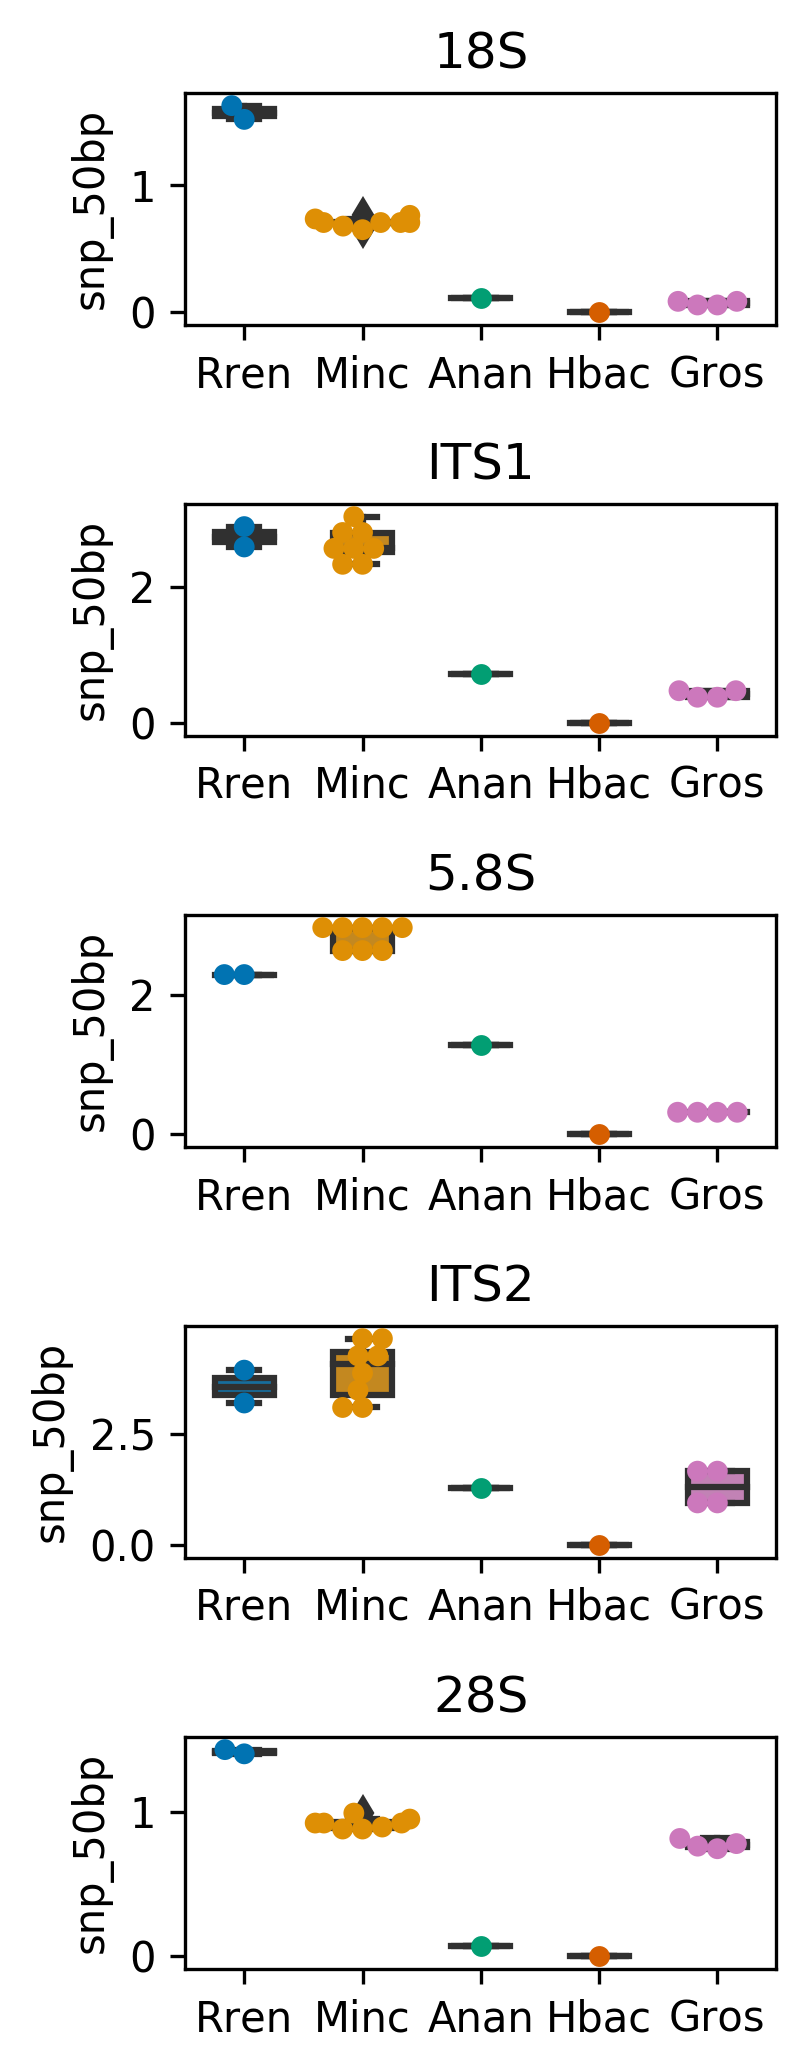

In [4]:
def add_species(string):
    return string[:4]
snp_all_plot['sp'] = snp_all_plot.Nematode.apply(add_species)
LSU = snp_all_plot.loc[snp_all_plot.Locus=='18S']

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
data = snp_all_plot
fig, axes = plt.subplots(nrows=len(set(data.Locus)),
                         tight_layout=True,
                         figsize=(2.8,7),
                         dpi=300)
locus_list = ['18S','ITS1','5.8S','ITS2','28S']
i = 0
for locus in locus_list:
    ax = axes[i]
    ax_data = data.loc[data.Locus==locus] 
    sns.boxplot(y='snp_50bp', x='sp', data=ax_data, width=0.5,palette="colorblind",ax=ax)
    sns.swarmplot(y='snp_50bp', x='sp', data=ax_data,palette="colorblind",ax=ax)
    ax.set_title(locus)
    ax.set_xlabel('')
    i += 1
plt.savefig('SRA_data/Figures/snp_rate_dist_per_sp.png')

# SNP heatmapes by species and genes separately

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import collections
%matplotlib inline
multisamples = [] #species with several samples
for smpl in sra_accessions:
    snp_by_sp = snp_all_plot.loc[snp_all_plot.sp==smpl[:4]]
    if len(snp_by_sp.index) > len(set(snp_by_sp.Locus)):
        multisamples.append(smpl[:4])
#User defined values, can be manualy adjusted to make figures look nice
d = collections.defaultdict(dict) #step dictionary, to divide long dataframes on axes by this step
d['Rren']['18S']  = 31
d['Rren']['ITS1'] = 100
d['Rren']['5.8S'] = 100
d['Rren']['ITS2'] = 100
d['Rren']['28S']  = 35
d['Minc']['18S']  = 32
d['Minc']['ITS1'] = 100
d['Minc']['5.8S'] = 100
d['Minc']['ITS2'] = 100
d['Minc']['28S']  = 42
d['Gros']['18S']  = 100
d['Gros']['ITS1'] = 100
d['Gros']['5.8S'] = 100
d['Gros']['ITS2'] = 100
d['Gros']['28S']  = 38
f = collections.defaultdict(dict) #figures sizes dictionary, for plotting heatmaps
f['Rren']['18S']  = [6,3]
f['Rren']['ITS1'] = [6.8,2.5]
f['Rren']['5.8S'] = [2.5,2.5]
f['Rren']['ITS2'] = [4,2.5]
f['Rren']['28S']  = [6.5,4]
f['Minc']['18S']  = [7,4]
f['Minc']['ITS1'] = [6.5,2.5]
f['Minc']['5.8S'] = [2.5,2.5]
f['Minc']['ITS2'] = [3.5,2.5]
f['Minc']['28S']  = [8,4]
f['Gros']['18S']  = [3,2]
f['Gros']['ITS1'] = [3,3]
f['Gros']['5.8S'] = [3,2]
f['Gros']['ITS2'] = [3,3]
f['Gros']['28S']  = [7,3]
cmap = sns.cm.rocket_r #reverse colors in heatmaps, dark - SNP, light - no SNP
!mkdir SRA_data/Figures/SNP_by_genes_and_species #making a subfolder for figures
for item in set(multisamples):
    snp_by_sp = snp_all.loc[snp_all_plot.sp==item]
    snp_by_sp = snp_by_sp.set_index(['Nematode'])
    for gene in set(snp_by_sp.Locus):
        position_list, positions = [],[]
        snp_by_gene = snp_by_sp.loc[snp_by_sp.Locus==gene]
        for index, row in snp_by_gene.iterrows():
            position_list.extend(snp_by_gene['Position'].tolist())
        positions = list(set([number for sublist in position_list for number in sublist]))
        positions.sort()
        if len(positions) > 0:
            df = pd.DataFrame(columns = positions, dtype=float)
            snp_heatmap = snp_by_gene.filter(items = ['Nematode'])
            snp_heatmap = pd.concat([snp_heatmap, df])
            for index, row in snp_by_gene.iterrows():
                for snp in list(snp_heatmap):
                    if snp in snp_by_gene.loc[index]['Position']: 
                        snp_heatmap.loc[index][snp] = 1
                    else:
                        snp_heatmap.loc[index][snp] = 0
            heatmap = snp_heatmap
            heatmap.to_csv("SRA_data/Figures/SNP_by_genes_and_species/%s_%s_snp.csv" % (item, gene), sep='\t')
            step = d[item][gene]
            if len(heatmap.columns) !=0 and len(heatmap.columns) %step ==0:
                n = len(heatmap.columns)/step
            else:
                n = len(heatmap.columns)//step + 1
            if n == 1:
                fig, ax = plt.subplots(tight_layout=True, dpi=300, figsize=(f[item][gene][0], f[item][gene][1]))
                sns.heatmap(data=heatmap, square=True, cbar=False, cmap = cmap)
                ax.set_title('%s %s' % (item, gene))
            else:
                fig, axes = plt.subplots(nrows = n, tight_layout=True, dpi=300, figsize=(f[item][gene][0], f[item][gene][1]))
                start = 0
                for i in range(n):
                    ax = axes[i]
                    stop = start + step
                    if len(heatmap.columns) > stop:
                        ax_data = heatmap.iloc[:,start:stop]
                    else:
                        ax_data = heatmap.iloc[:,start:len(heatmap.columns)]
                    start = stop
                    sns.heatmap(data=ax_data,ax=ax, square=True, cbar=False, cmap = cmap)
                    ax.set_title('%s %s part %s' % (item, gene, i+1))
            plt.xticks(rotation=90) 
            plt.savefig("SRA_data/Figures/SNP_by_genes_and_species/%s_%s_snp.png" % (item, gene), dpi=300)